In [1]:
from env import *

## Read data and select learners

In [2]:
lcdb_df = pd.read_csv(os.path.expanduser('~/Documents/data/delegated_classification/lcdb/database/database-accuracy.csv'))
lcdb_df.head()

,openmlid,learner,size_train,size_test,outer_seed,inner_seed,traintime,score_train,score_valid,score_test
0,44,SVC_linear,16,461,0,0,0.0024,0.8750,0.7440,0.7072
1,44,SVC_linear,23,461,0,0,0.0014,0.9565,0.7222,0.6876
2,44,SVC_linear,32,461,0,0,0.0017,0.9375,0.7295,0.7180
3,44,SVC_linear,45,461,0,0,0.0023,0.9778,0.8237,0.8048
4,44,SVC_linear,64,461,0,0,0.0033,0.7812,0.6280,0.6508


In [3]:
closest_ind = lambda arr, val: np.argmin(np.abs(np.array(arr)-val))

build_cdp = lambda learner, m: (
    lcdb_df
    .query('openmlid==@selected_openmlid and learner==@learner')
    .groupby('size_train')
    ['score_test']
    .agg(list)
    .pipe(
        dclf.BootstrappedBinomialMixtureContractDesignProblem.from_series,
        m=m,
        ensure_zero_cost_action=True,
    )
)

## Ridgeline plot

Figure saved as ./output/contract_types_schematic_comparison.pdf


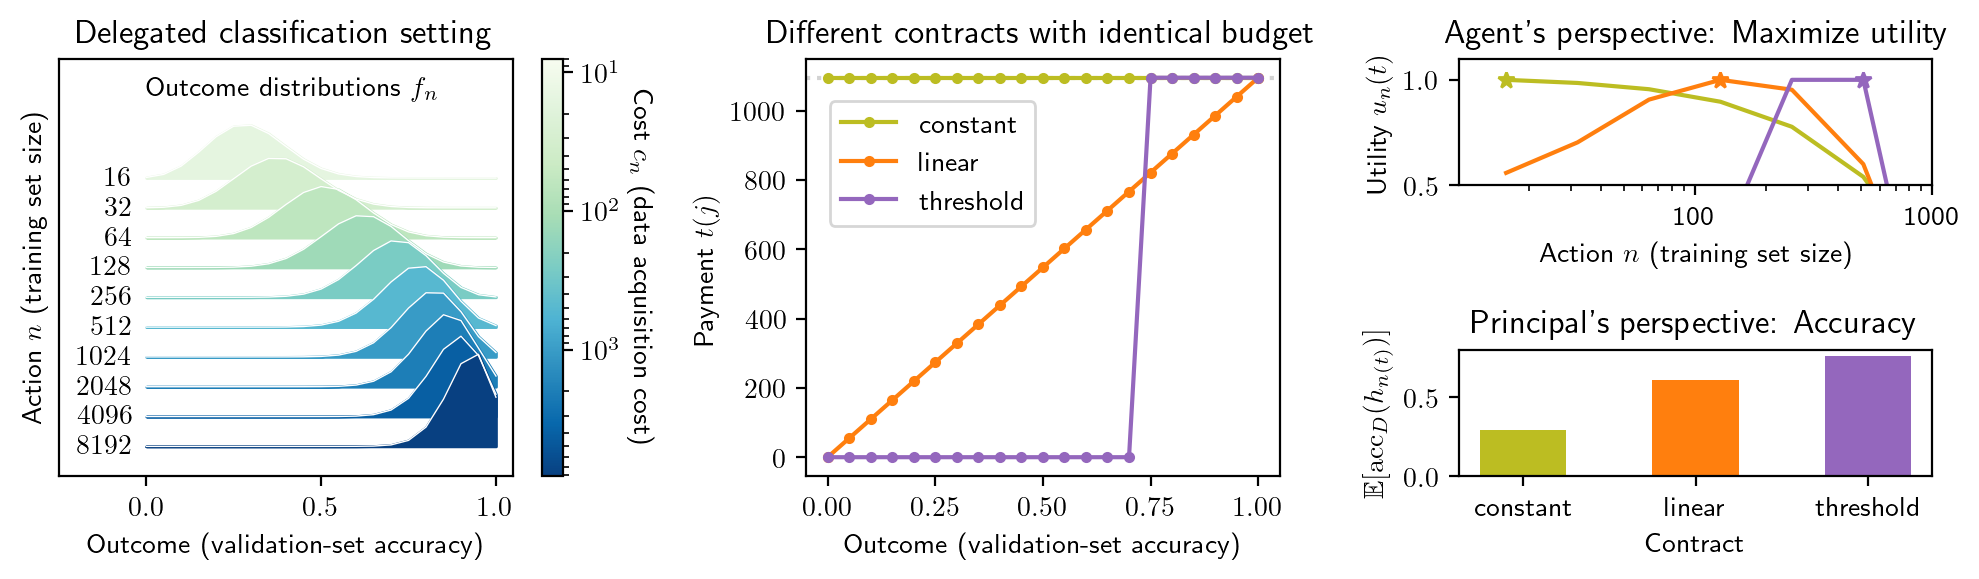

In [4]:
selected_learner = 'sklearn.neural_network.MLPClassifier'
selected_openmlid = dclf.mnist_openmlid

i_vec = np.arange(1,20,2)

K = param(20, 'm')
orig_cdp = build_cdp(selected_learner,K)
acc_vec = np.array(orig_cdp.mean_acc)[i_vec]
n_vec = np.array(orig_cdp.cost)[i_vec]
f_ij = orig_cdp.f_ij[i_vec]
cost = n_vec

fig = plt.figure(figsize=(10,3), layout='tight')
gs = matplotlib.gridspec.GridSpec(2, 3, width_ratios=[1.2,1,1])
axs = np.array([
    fig.add_subplot(gs[:, 0]),
    fig.add_subplot(gs[:, 1]),
    fig.add_subplot(gs[0, 2]),
    fig.add_subplot(gs[1, 2]),
])

axs_it = iter(axs.ravel())

#
# Ridgeline plot
#

ax = next(axs_it)
offset_multiplier = 0.1
x = np.arange(f_ij.shape[1])/K
n = f_ij.shape[0]

cmap = matplotlib.colormaps['GnBu']
norm = matplotlib.colors.LogNorm(vmin=cost.min()/2, vmax=cost.max())

for i in range(n):
    offset = (n-(i+1))*offset_multiplier
    color = cmap(norm(cost[i]))
    ax.fill_between(
        x,
        offset,
        offset+f_ij[i],
        color=color,
    )
    ax.plot(
        x,
        offset+f_ij[i],
        color='white',
        linewidth=0.5,
    )
    ax.annotate(
        # f'$f_{{ {i} }}$',
        f'${n_vec[i]}$',
        xy=(0,offset),
        textcoords='offset points',
        xytext=(-5,0),
        va='center',
        ha='right',
    )
    
ax.annotate(
    'Outcome distributions $f_n$',
    xy=(0,(n+2)*offset_multiplier),
    ha='left',
    va='center',
)

ax.set_yticks([])

action_label = 'Action $n$ (training set size)'
outcome_label = 'Outcome (validation-set accuracy)'

ax.set(
    ylabel=action_label,
    xlabel=outcome_label,
    xlim=(-x.max()*0.25,None),
    ylim=(-0.1,(n+3)*offset_multiplier),
    title='Delegated classification setting',
)

cbar = ax.figure.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cbar.ax.get_yaxis().labelpad = 12
cbar.ax.set_ylabel('Cost $c_n$ (data acquisition cost)', rotation=270)
cbar.ax.invert_yaxis()

#
# Different contracts
#

cdp = dclf.ContractDesignProblem(f_ij, cost)

target_action = len(f_ij)-4
cdp_reduced = dclf.ContractDesignProblem(f_ij[:target_action], cost[:target_action])

t_opt = dclf.MinBudgetContract.design(cdp_reduced)['t']
B = t_opt.max()
t_const = B*np.ones(t_opt.shape[0])
t_linear = B*np.arange(t_opt.shape[0])/(t_opt.shape[0]-1)
contracts = {
    'constant': (t_const, 'tab:olive'),
    'linear': (t_linear, 'tab:orange'),
    'threshold': (t_opt, 'tab:purple'),
}

ax = next(axs_it)

for contract_name, (t,c) in contracts.items():
    ax.plot(
        x,
        t,
        '.-',
        color=c,
        label=contract_name,
    )
ax.axhline(B, linestyle=':', color='lightgray', zorder=-1)
ax.legend(
    loc=(0.05,0.6),
)
ax.set(
    title='Different contracts with identical budget',
    ylabel='Payment $t(j)$',
    xlabel=outcome_label,
)

ax = next(axs_it)
for contract_name, (t,c) in contracts.items():
    response = dclf.get_agent_response(
        cdp,
        t,
    )
    ax.plot(
        n_vec,
        response.utility/response.selected_action_utility,
        '-',
        color=c,
    )
    ax.plot(
        n_vec[response.selected_action],
        1,
        '*',
        color=c,
    )

#
# Agent's perspective
#

ax.set(
    title='Agent\'s perspective: Maximize utility',
    ylabel='Utility $u_n(t)$',
    xlabel=action_label,
    xscale='log',
    # ylim=(-0.1,None),
    ylim=(0.5,1.1),
    xlim=(10.1,1000),
)
ax.xaxis.set_major_formatter(lambda x, pos: f'{x:g}')


#
# Principal's perspective
#

ax = next(axs_it)

x = []
y = []
y_accs = []
colors = []
for contract_name, (t,c) in contracts.items():
    response = dclf.get_agent_response(
        cdp,
        t,
    )
    x.append(contract_name)
    y.append(acc_vec[response.selected_action])
    y_accs.append(np.array(orig_cdp.acc_p,dtype=object)[i_vec][response.selected_action])
    colors.append(c)
    
ax.bar(
    x,
    y,
    color=colors,
    width=0.5,
    # yerr=pd.Series(y_accs).apply(dclf.describe_series_of_samples).pipe(lambda df: df['std_ub']-df['mean']),
    # ecolor=[np.array(matplotlib.colors.to_rgb(c))*0.7 for c in colors],
    # capsize=2,
)

ax.set(
    title='Principal\'s perspective: Accuracy',
    ylabel=r'$\mathbb{E}[\mathrm{acc}_D(h_{n(t)})]$',
    xlabel='Contract',
    # ylim=(0.45,None),
)

fig.tight_layout(w_pad=1, h_pad=1.5)

dclf.save_and_download_fig(fig,'./output/contract_types_schematic_comparison.pdf')
tracker.save('./output/ridgeline.json')